# Teste


In [1]:
%pip install -qqq datasetsforecast mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 13.8 MB/s eta 0:00:00


In [2]:
import random

import matplotlib.pyplot as plt
import pandas as pd
from datasetsforecast.m4 import M4, M4Evaluation, M4Info
from mlforecast.lgb_cv import LightGBMCV
from window_ops.expanding import expanding_mean
from window_ops.ewm import ewm_mean
from window_ops.rolling import rolling_mean, seasonal_rolling_mean

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


key='15QvR-hLmEs4dNixJnsuZku_ZBtPiNkRA7Dav2Srp8o8'
link='https://docs.google.com/spreadsheet/ccc?key='+key+'&output=csv'

df = pd.read_csv(link, sep=',',index_col='Data', )

df = df.apply(pd.to_numeric, errors='coerce')
df=df[['Vazão',
       'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
       'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
       #'TEMPERATURA MAXIMA, DIARIA (AUT)(°C)',
       'TEMPERATURA MEDIA, DIARIA (AUT)(°C)',
       #'TEMPERATURA MINIMA, DIARIA (AUT)(°C)',
       'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)',
       #'UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)',
       #'VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)',
       #'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)',
       ]]

df.columns

cols = df.columns
#cols.remove(None)
for col in cols:
    df[col] = df[col].astype(float)
    df[col] = df[col]/df[col].max()


df.index = pd.to_datetime(pd.to_datetime(df.index), unit='D')

df1= pd.DataFrame(index= df.asfreq('d').index)
df2=pd.merge(df1, df, how='outer', left_index=True, right_index=True)
df2

df=df2
df.fillna(0,inplace=True)
df.columns

Index(['Vazão', 'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
       'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
       'TEMPERATURA MEDIA, DIARIA (AUT)(°C)',
       'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)'],
      dtype='object')

In [4]:
forecast_horizon=360

targets=['Vazão']
exogenous=[
    #'Vazão',
    'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
    'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
    #'TEMPERATURA MAXIMA, DIARIA (AUT)(°C)',
    'TEMPERATURA MEDIA, DIARIA (AUT)(°C)',
    #'TEMPERATURA MINIMA, DIARIA (AUT)(°C)',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)',
    #'UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)',
    #'VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)',
    #'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)',
    ]

# training set
df1=df[:-forecast_horizon]
series=pd.DataFrame()
for i,t in enumerate(targets):
  print(i,t)
  aux=pd.DataFrame()
  aux['ds']=df1[[t]].index
  aux['unique_id']=i+1
  aux['y']=df1[t].values

  for j,c in enumerate(exogenous):
    aux['var'+str(j+1)]=df1[c].values
    #aux[c]=df1[c].values

  series=pd.concat([series,aux])

series_train=series

# test set
df1=df[-forecast_horizon:]
series=pd.DataFrame()
for i,t in enumerate(targets):
  print(i,t)
  aux=pd.DataFrame()
  aux['ds']=df1[[t]].index
  aux['unique_id']=i+1
  aux['y']=df1[t].values

  for j,c in enumerate(exogenous):
    aux['var'+str(j+1)]=df1[c].values
    #aux[c]=df1[c].values

  series=pd.concat([series,aux])

series_test=series

0 Vazão
0 Vazão


In [5]:
series_train

,ds,unique_id,y,var1,var2,var3,var4
0,2016-09-02,1,0.071331,0.045944,0.987801,0.751315,0.701349
1,2016-09-03,1,0.058602,0.045944,0.987801,0.751315,0.701349
2,2016-09-04,1,0.068217,0.045944,0.987801,0.751315,0.701349
3,2016-09-05,1,0.087263,0.045944,0.987801,0.751315,0.701349
4,2016-09-06,1,0.077849,0.045944,0.991142,0.656000,0.903529
...,...,...,...,...,...,...,...
1033,2019-07-02,1,0.041478,0.000000,0.983928,0.690429,0.401128
1034,2019-07-03,1,0.040841,0.000000,0.982258,0.743000,0.386489
1035,2019-07-04,1,0.048440,0.161290,0.984062,0.645000,0.701349
1036,2019-07-05,1,0.128129,0.360215,0.987801,0.529286,0.701349


In [6]:
series_test

,ds,unique_id,y,var1,var2,var3,var4
0,2019-07-07,1,0.145505,0.002688,0.996261,0.378571,0.519827
1,2019-07-08,1,0.133618,0.000000,0.996304,0.431000,0.443791
2,2019-07-09,1,0.111949,0.000000,0.995668,0.461143,0.458813
3,2019-07-10,1,0.101998,0.000000,0.993808,0.507857,0.440661
4,2019-07-11,1,0.096945,0.002688,0.991250,0.527571,0.381906
...,...,...,...,...,...,...,...
355,2020-06-26,1,0.034590,0.002688,0.989022,0.662714,0.773660
356,2020-06-27,1,0.051986,0.010753,0.987972,0.538143,0.884660
357,2020-06-28,1,0.000000,0.000000,0.000000,0.000000,0.000000
358,2020-06-29,1,0.065492,0.000000,0.991713,0.583571,0.744033


In [7]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

models = [
    lgb.LGBMRegressor(verbosity=-1),
    #xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
    #LinearRegression(),
]

In [12]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean


@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)


fcst = MLForecast(
    models=models,
    freq='D',
    lags=[1,7],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7]
    },
    date_features=['month',],
    target_transforms=[Differences([1])],
)

In [13]:
fcst.fit(series_train,)

MLForecast(models=[LGBMRegressor, RandomForestRegressor], freq=D, lag_features=['lag1', 'lag7', 'expanding_mean_lag1', 'rolling_mean_7_lag7'], date_features=['month'], num_threads=1)

In [14]:
predictions = fcst.predict(forecast_horizon)
predictions

,unique_id,ds,LGBMRegressor,RandomForestRegressor
0,1,2019-07-07,0.148096,0.148373
1,1,2019-07-08,0.146806,0.151748
2,1,2019-07-09,0.146000,0.155667
3,1,2019-07-10,0.144899,0.159442
4,1,2019-07-11,0.144644,0.158156
...,...,...,...,...
355,1,2020-06-26,0.194952,0.197259
356,1,2020-06-27,0.196223,0.194220
357,1,2020-06-28,0.195775,0.195971
358,1,2020-06-29,0.196114,0.195329


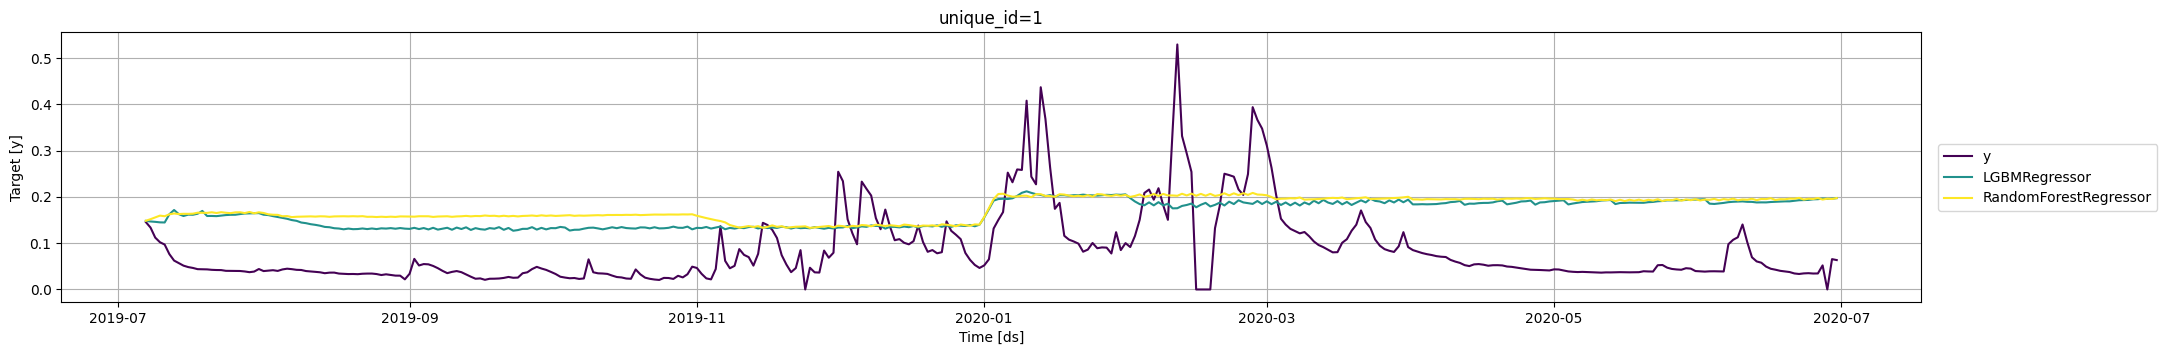

In [15]:
from utilsforecast.plotting import plot_series
plot_series(series_test, predictions, max_ids=8, plot_random=False)
